# Definición del modelo:

`main.py` :

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import  torchvision.transforms.functional as TF

# Bloque de código de cada capa de la Unet (donde se aplican las dos convoluciones, Además se aplica el btchnorm):
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(
        self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size = 2, stride=2)

        # Down part of Unet:
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of Unet:
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2) # Medium part
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1) #Final part


    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


def test():
    x = torch.randn((3, 1, 160, 160))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

In [2]:
test()

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


`dataset.py` :

In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np


class MiccaiDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform =  transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        return image, mask

`utils.py`:

In [4]:
import torch
import torchvision
import os
# from dataset import MiccaiDataset
from torch.utils.data import DataLoader

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory = True,
):
    train_ds = MiccaiDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = MiccaiDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader

def check_metrics(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    true_positive = 0
    false_positive = 0
    false_negative = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds =  (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += (torch.numel(preds))
            dice_score += (2* (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
            true_positive += ((preds == 1) & (y == 1)).sum()
            false_positive += ((preds == 1) & (y == 0)).sum()
            false_negative += ((preds == 0) & (y == 1)).sum()

    # Calculate metrics:
    accuracy = num_correct / num_pixels if num_pixels > 0 else 0 # Calculate accuracy
    dice_coefficient = dice_score / len(loader) if len(loader) > 0 else 0
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print metrics:
    print(f"Got {num_correct}/{num_pixels} with acc {accuracy*100:.3f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()
    return dice_coefficient, accuracy, precision, recall, f1_score

def save_predictions_as_imgs(
        loader, model, folder="output_assets_model_otherv_otherv_otherv_otherv/saved_images/", device="cuda"
):
    if not os.path.exists(folder):
        os.makedirs(folder)
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds, f"{folder}/pred_{idx}.png"
        )
        # torchvision.utils.save_image(y.unsqueeze(1), f"{folder}")  # para colab
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}/target_{idx}.png")

    model.train()


## Otros:

def replace_backslashes(input_string):
  """Replaces all backslashes '\' in a string with forward slashes '/'."""
  return input_string.replace("\\", "/")
# ex: a = replace_backslashes(r"C:\Users\user\Documents\file.txt")

`train.py` :

In [5]:
from re import L
import zipfile
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import pandas as pd


def dice_loss(input, target):
    smooth = 1.0
    input = torch.sigmoid(input)  # Aplicar sigmoide para obtener probabilidades
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) /
                (iflat.sum() + tflat.sum() + smooth))


# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 4
# NUM_EPOCHS = 83
NUM_WORKERS = 0
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
PIN_MEMORY = True
LOAD_MODEL = True
SAVE_IMS = True

TRAIN_IMG_DIR = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/train_images"
TRAIN_MASK_DIR = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/train_masks"
VAL_IMG_DIR = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/val_images"
VAL_MASK_DIR = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/val_masks"

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    total_loss = 0  # Inicializar la pérdida total
    num_batches = 0  # Inicializar el contador de batches

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward:
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward:
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item)

        # Acumular la pérdida y contar los batches
        total_loss += loss.item()
        num_batches += 1

    avg_loss = total_loss / num_batches

    return avg_loss  # Devolver la pérdida promedio


def main(NUM_EPOCHS=10):
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )
    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2()
        ],
    )

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    # loss_fn = nn.BCEWithLogitsLoss()
    loss_fn = dice_loss
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5) # Reduce LR if validation loss plateaus

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY
    )

    # if LOAD_MODEL:
    #     load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

    scaler = torch.cuda.amp.GradScaler()
    L_dice = []
    L_loss = []
    L_accuracy = []
    L_precision = []
    L_recall = []
    L_f1_score = []
    best_dice_score = 0.0

    for epoch in range(NUM_EPOCHS):
        print(f"Epoch: {epoch + 1}")
        epoch_loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)
        L_loss.append(epoch_loss)
        scheduler.step(epoch_loss) # Update scheduler based on training loss

        # Check accuracy on validation set
        dc, acc, prec, rec, f1_s = check_metrics(val_loader, model, device=DEVICE)
        L_dice.append(dc)
        L_accuracy.append(acc)
        L_precision.append(prec)
        L_recall.append(rec)
        L_f1_score.append(f1_s)

        # Save best model, based in dice score.
        if dc > best_dice_score:
          best_dice_score = dc
          checkpoint = {
              "state_dict": model.state_dict(),
              "optimizer": optimizer.state_dict(),
          }
          # torch.save(checkpoint, f"model_checkpoint_epoch_{epoch+1}.pth")


          # Guardar el modelo en .pth y en .zip:
          torch.save(checkpoint, "output_assets_model_otherv/best_model_checkpoint.pth")
          # torch.save(checkpoint, "my_checkpoint.pth.tar")
          with zipfile.ZipFile("output_assets_model_otherv_otherv/best_model_checkpoint.zip", 'w') as zipf:
            zipf.write("output_assets_model_otherv/best_model_checkpoint.pth")

        # Save some example predictions to a folder
        if SAVE_IMS:
            save_predictions_as_imgs( val_loader, model, folder="output_assets_model_otherv/saved_images/", device=DEVICE)

    # Save metrics for each epoch:
        # Convert L_dice_result and L_acc_result to NumPy arrays:
    L_dice = [x.cpu().numpy() for x in L_dice]
    L_accuracy = [x.cpu().numpy() for x in L_accuracy]
    L_precision = [x.cpu().numpy() for x in L_precision]
    L_recall = [x.cpu().numpy() for x in L_recall]
    L_f1_score = [x.cpu().numpy() for x in L_f1_score]
        # Crear un DataFrame con las listas y las épocas
    data = {'Epoch': range(1, len(L_dice) + 1), 'Dice Score': L_dice, 'Loss': L_loss, 'Accuracy': L_accuracy, 'Precision': L_precision, 'Recall': L_recall, 'F1 Score': L_f1_score}
    df = pd.DataFrame(data)
    df.to_csv('output_assets_model_otherv/metrics.csv', index=False)     # Guardar el DataFrame en un archivo CSV
            
    return model, L_dice, L_loss, L_accuracy, L_precision, L_recall, L_f1_score

c:\Users\am969\anaconda3\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
DEVICE  # Check the device

device(type='cuda')

## Entrenamos el modelo:

In [7]:
trained_model, L_dice_result, L_loss_result, L_acc_result, L_prec_result, L_rec_result, L_f1s_result = main(NUM_EPOCHS = 3)

C:\Users\am969\AppData\Local\Temp\ipykernel_9908\3598543546.py:119: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch: 1


  0%|          | 0/202 [00:00<?, ?it/s]C:\Users\am969\AppData\Local\Temp\ipykernel_9908\3598543546.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 202/202 [00:48<00:00,  4.14it/s, loss=<built-in method item of Tensor object at 0x000001CA4EAE34D0>]


Got 5441991/5817600 with acc 93.544
Dice score: 0.26774901151657104
Epoch: 2


100%|██████████| 202/202 [00:48<00:00,  4.20it/s, loss=<built-in method item of Tensor object at 0x000001CA0941DE50>]


Got 5704787/5817600 with acc 98.061
Dice score: 0.5058942437171936
Epoch: 3


100%|██████████| 202/202 [00:48<00:00,  4.20it/s, loss=<built-in method item of Tensor object at 0x000001CA4EAE2690>]


Got 5736059/5817600 with acc 98.598
Dice score: 0.5955513715744019


In [8]:
# Carga el modelo con las mejores métricas (guardado en el archivo output_assets_model_otherv/best_model_checkpoint.pth) asignándolo a la variable model_best_result.

import torch

# Assuming 'output_assets_model_otherv/best_model_checkpoint.pth' is in the current working directory.
# If not, adjust the path accordingly.
checkpoint = torch.load("output_assets_model_otherv/best_model_checkpoint.pth")

# Assuming UNET class is defined in the current scope
# If not, make sure the definition of UNET is available before this line
model_best_result = UNET(in_channels=3, out_channels=1).to(DEVICE)
model_best_result.load_state_dict(checkpoint["state_dict"])
# model_best_result.eval() #set to evaluation mode

C:\Users\am969\AppData\Local\Temp\ipykernel_9908\1416009582.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("output_assets_model/best_model_check

<All keys matched successfully>

# Hacer predicciones con el modelo:

In [9]:
# CARGAR EL MODELO DEL ZIP (solo para guardar este código):
# prompt: Ahora dame el código con el que lo cargaría en el otro script, asignándolo a la variable model_best_result

import torch
# from model import UNET  # Assuming your UNET class is in a file named model.py
import zipfile

def load_model_from_zip(zip_filename, device="cpu"):
  """Loads a PyTorch model from a zip file.

  Args:
    zip_filename: The name of the zip file containing the model weights.
    device: The device to load the model onto (e.g., "cuda" or "cpu").

  Returns:
    The loaded PyTorch model.
  """

  with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extractall()


  model = UNET(in_channels=3, out_channels=1).to(device)
  # checkpoint = torch.load("output_assets_model_otherv/best_model_checkpoint.pth")
  model.load_state_dict(torch.load("output_assets_model_otherv/best_model_checkpoint.pth", map_location=device)["state_dict"])
  # model.load_state_dict(checkpoint["state_dict"])

  return model


# Example of how to load the model
model_best_result_loaded = load_model_from_zip("output_assets_model_otherv/best_model_checkpoint.zip", device=DEVICE)

C:\Users\am969\AppData\Local\Temp\ipykernel_9908\3285450786.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("output_assets_model/best_m

In [11]:
# prompt: Obtén el path de una imágen escogida aleatoriamente del folder C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/test_images

import os
import random

def get_random_image_path(folder_path):
  """
  Obtiene el path de una imagen escogida aleatoriamente del folder especificado.

  Args:
    folder_path: Ruta a la carpeta que contiene las imágenes.

  Returns:
    Path de la imagen aleatoria, o None si la carpeta está vacía.
  """
  image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
  if not image_files:
    return None
  random_image_file = random.choice(image_files)
  return os.path.join(folder_path, random_image_file)


image_folder = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/test_images"

random_image_path = get_random_image_path(image_folder)

if random_image_path:
  print(f"Path de la imagen aleatoria: {random_image_path}")
else:
  print(f"La carpeta '{image_folder}' está vacía.")

Path de la imagen aleatoria: C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/test_images\0899.png


In [12]:
# TOMA EL MODELO CARGADO EN LA CELDA ANETERIOR Y HACE UNA PREDICCIÓN:
# prompt: Ahora haz la predicción (y muéstrala) de una imagen de mi carpeta /content/FootSegmentation_4/images-unet/IMs29Ago/test_images      con el modelo que acabo de entrenar

# Assuming your model is named 'model' and is already loaded with the trained weights.
# You'll need to adjust the paths and file names as needed.

import torch
import torchvision
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import os

# Define the path to the image you want to predict
image_path = random_image_path  # Replace with your image path

# Load the image
image = np.array(Image.open(image_path).convert("RGB"))

# Apply the same transformations used during training
val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

augmentations = val_transforms(image=image)
image = augmentations["image"]

# Move the image to the device (CPU or GPU)
image = image.unsqueeze(0).to(DEVICE)


# Make the prediction
with torch.no_grad():
  prediction = torch.sigmoid(model_best_result_loaded(image))
  prediction = (prediction > 0.5).float()
# Resize the prediction to 512x512
prediction = torchvision.transforms.functional.resize(prediction, size=(512, 512))

# # Save the prediction as an image (versión anterior, para guardar la predicción sin la imagen de entrada)
# torchvision.utils.save_image(prediction, "output_assets_model_otherv/predicted_mask_example.png")

# Save the prediction and the input image side by side:
def save_input_and_prediction(input_image, predicted_mask, save_path):
    # Asegúrate de que las imágenes estén en formato numpy arrays
    input_image = input_image.cpu().numpy().transpose(1, 2, 0)  # Convertir de (C, H, W) a (H, W, C)
    predicted_mask = predicted_mask.cpu().numpy().squeeze()  # Eliminar dimensiones innecesarias

    # Crear una figura con dos subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Mostrar la imagen de entrada
    axes[0].imshow(input_image)
    axes[0].set_title("Imagen de Entrada")
    axes[0].axis("off")

    # Mostrar la máscara predicha
    axes[1].imshow(predicted_mask, cmap="gray")
    axes[1].set_title("Máscara Predicha")
    axes[1].axis("off")

    # Guardar la figura como una imagen
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path)
    plt.close(fig)

    print(f"Imagen guardada en: {save_path}")

# print(image.shape, prediction.shape)
# print(type(image), type(prediction))
save_input_and_prediction(image[0], prediction[0], "output_assets_model_otherv/predicted_mask_example.png")

Imagen guardada en: output_assets_model/predicted_mask_example.png


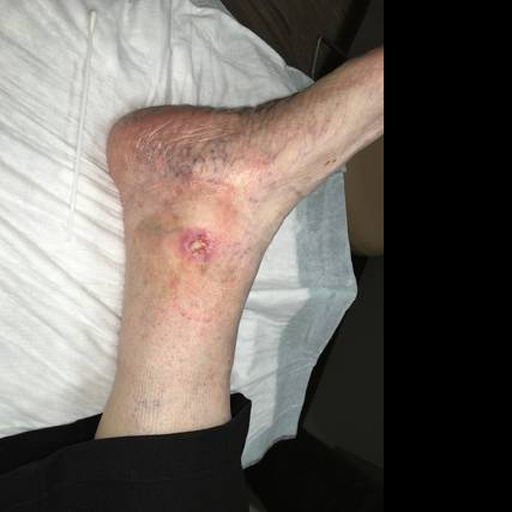

In [13]:
Image.open(random_image_path)

# Gráficas de dice y loss funct. por cada época:

Gráfica guardada en: output_assets_model/dice_loss_graph.png


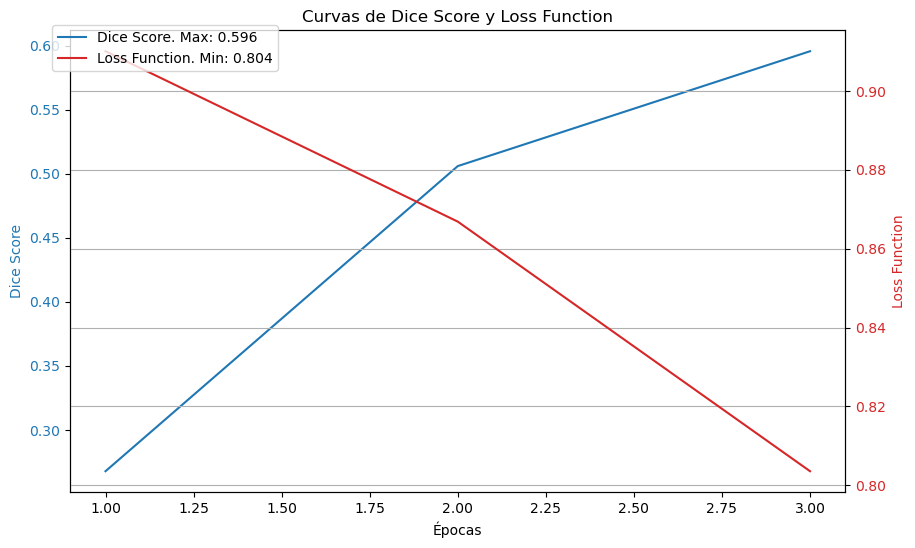

In [14]:
# prompt: Graficame [1,2,3] vs [4,5,6] en una gráfica elegante y bonita

import matplotlib.pyplot as plt

# Datos de ejemplo (reemplaza con tus datos reales)
epochs = range(1, len(L_dice_result) + 1)

# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Graficar la curva de Dice Score
color = 'tab:blue'
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Dice Score', color=color)
ax1.plot(epochs, L_dice_result, color=color, label=f'Dice Score. Max: {max(L_dice_result):.3f}')
ax1.tick_params(axis='y', labelcolor=color)

# Crear un segundo eje y para la Loss Function
ax2 = ax1.twinx()  # Compartir el eje x

color = 'tab:red'
ax2.set_ylabel('Loss Function', color=color)
ax2.plot(epochs, L_loss_result, color=color, label=f'Loss Function. Min: {min(L_loss_result):.3f}')
ax2.tick_params(axis='y', labelcolor=color)

# Agregar leyenda y título
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.title('Curvas de Dice Score y Loss Function')

# Guardado de la gráfica:
plt.savefig("output_assets_model_otherv/dice_loss_graph.png")
print(f"Gráfica guardada en: output_assets_model_otherv/dice_loss_graph.png")

# Mostrar la gráfica
plt.grid(True)
plt.show()

# Métricas con el test set:

In [15]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np

def get_test_loader(test_image_dir, test_mask_dir, batch_size=BATCH_SIZE, image_height=240, image_width=240, num_workers=0, pin_memory=True):
    val_transforms = A.Compose(
        [
            A.Resize(height=image_height, width=image_width),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ]
    )

    test_ds = MiccaiDataset(
        image_dir=test_image_dir,
        mask_dir=test_mask_dir,
        transform=val_transforms,
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return test_loader


def calculate_metrics(test_image_dir, test_mask_dir, model, device=DEVICE, image_height=240, image_width=240, num_workers=0, batch_size=BATCH_SIZE, pin_memory=True):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    true_positive = 0
    false_positive = 0
    false_negative = 0
    model.eval()

    loader = get_test_loader(test_image_dir, test_mask_dir, batch_size= batch_size,  image_height=image_height, image_width=image_width, num_workers=num_workers, pin_memory=pin_memory)

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)
            true_positive += ((preds == 1) & (y == 1)).sum()
            false_positive += ((preds == 1) & (y == 0)).sum()
            false_negative += ((preds == 0) & (y == 1)).sum()

    accuracy = num_correct / num_pixels if num_pixels > 0 else 0
    dice_coefficient = dice_score / len(loader) if len(loader) > 0 else 0
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    model.train() # regresarlo a su estado original si se quiere seguir entrenando el modelo.

    return accuracy, dice_coefficient, precision, recall, f1_score



# Calculamos las métricas del test set:
test_image_dir = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/test_images"
test_mask_dir = "C:/Users/am969/Documents/DFU_Proyect/SegmentationNetworks/data_DFU_images/data_MICCAI/test_masks"
batch_size = 4

accuracy, dice_coefficient, precision, recall, f1_score = calculate_metrics(test_image_dir, test_mask_dir, model_best_result_loaded, device=DEVICE, image_height=240, image_width=240)
print(f"Accuracy: {accuracy:.4f}")
print(f"Dice Coefficient: {dice_coefficient:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.9854
Dice Coefficient: 0.5775
Precision: 0.4196
Recall: 0.8869
F1 Score: 0.5697


In [16]:
# Best metrics (validation set during training):
print(f"Best_accuracy: {max(L_acc_result):.4f}")
print(f"Best_dice: {max(L_dice_result):.4f}")
print(f"Best_precision: {max(L_prec_result):.4f}")
print(f"Best_recall: {max(L_rec_result):.4f}")
print(f"Best_f1_score: {max(L_f1s_result):.4f}")
print("---------------------------------")
print(f"Best_loss: {min(L_loss_result):.4f}")
print(f"Best_epoch: {L_dice_result.index(max(L_dice_result))+1}")

Best_accuracy: 0.9860
Best_dice: 0.5956
Best_precision: 0.4573
Best_recall: 0.9443
Best_f1_score: 0.5902
---------------------------------
Best_loss: 0.8035
Best_epoch: 3


In [17]:
# Best metrics (validation set out of training):
batch_size = 4

accuracy, dice_coefficient, precision, recall, f1_score = calculate_metrics(VAL_IMG_DIR, VAL_MASK_DIR, model_best_result_loaded, device=DEVICE)
print(f"Accuracy: {accuracy:.4f}")
print(f"Dice Coefficient: {dice_coefficient:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.9838
Dice Coefficient: 0.5684
Precision: 0.4190
Recall: 0.8589
F1 Score: 0.5632
